In [ ]:
#Install and import Ultralytics YOLO
!pip install ultralytics --quiet

from ultralytics import YOLO
import os
import zipfile
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import yaml

from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

with zipfile.ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/brain_tumor_data")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 146M/149M [00:00<00:00, 556MB/s] 
100% 149M/149M [00:00<00:00, 564MB/s]


In [ ]:
#Convert classification data to YOLOv8 detection format (fake boxes)
import cv2

def create_fake_box(img_path):
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    #Simulate a bounding box in the center
    box_w, box_h = w // 2, h // 2
    x_center = w // 2
    y_center = h // 2

    #Normalize
    x_center /= w
    y_center /= h
    box_w /= w
    box_h /= h
    return [x_center, y_center, box_w, box_h]

#Organize dataset for YOLO
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_to_id = {name: idx for idx, name in enumerate(classes)}

#Preparing directory structure
for split in ['train', 'val']:
    os.makedirs(f'dataset/images/{split}', exist_ok=True)
    os.makedirs(f'dataset/labels/{split}', exist_ok=True)

base_path = '/content/brain_tumor_data/Training'
split_ratio = 0.8

for class_name in classes:
    img_dir = os.path.join(base_path, class_name)
    imgs = os.listdir(img_dir)
    random.shuffle(imgs)
    split = int(len(imgs) * split_ratio)
    train_imgs = imgs[:split]
    val_imgs = imgs[split:]

    for phase, phase_imgs in zip(['train', 'val'], [train_imgs, val_imgs]):
        for img_name in phase_imgs:
            img_path = os.path.join(img_dir, img_name)
            dest_img_path = f'dataset/images/{phase}/{class_name}_{img_name}'
            shutil.copy(img_path, dest_img_path)

            #Writing fake label for detection
            box = create_fake_box(img_path)
            label_file = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
            label_path = f'dataset/labels/{phase}/{class_name}_{label_file}'
            with open(label_path, 'w') as f:
                f.write(f"{class_to_id[class_name]} {' '.join(map(str, box))}\n")

#Create YAML config for YOLO
yaml_dict = {
    'path': '/content/dataset',
    'train': 'images/train',
    'val': 'images/val',
    'names': classes
}

with open('/content/dataset/data.yaml', 'w') as outfile:
    yaml.dump(yaml_dict, outfile)

#Train YOLOv8n model
model = YOLO('yolov8n.pt')
model.train(data='/content/dataset/data.yaml', epochs=10, imgsz=150)


100%|██████████| 6.25M/6.25M [00:00<00:00, 72.8MB/s]


Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=150, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True,

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    752092  ultralytics.nn.modules.head.Detect           [4, [64, 128, 256]]           
Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
WARNING ⚠️ imgsz=[150] must be multiple of max stride 32, updating to [160]
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 641.9±382.0 MB/s, size: 16.5 KB)


train: Scanning /content/dataset/labels/train... 4568 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4568/4568 [00:02<00:00, 1726.34it/s]


train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 708.6±430.0 MB/s, size: 19.8 KB)


val: Scanning /content/dataset/labels/val... 1144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1144/1144 [00:00<00:00, 2033.04it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 160 train, 160 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.329      1.891      1.342          8        160: 100%|██████████| 286/286 [05:03<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:35<00:00,  1.00it/s]

                   all       1144       1144      0.795      0.875      0.868      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.9135      1.028      1.041          8        160: 100%|██████████| 286/286 [04:58<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:35<00:00,  1.01it/s]

                   all       1144       1144      0.719      0.842      0.858      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      0.827     0.8365      1.002          8        160: 100%|██████████| 286/286 [04:56<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:33<00:00,  1.08it/s]

                   all       1144       1144      0.695      0.766      0.833      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      0.763     0.7383     0.9822          8        160: 100%|██████████| 286/286 [04:56<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:36<00:00,  1.02s/it]

                   all       1144       1144       0.77      0.854      0.907      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.7027     0.6259     0.9546          8        160: 100%|██████████| 286/286 [04:56<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:33<00:00,  1.07it/s]

                   all       1144       1144       0.91      0.862      0.967      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.6701     0.5722     0.9437          8        160: 100%|██████████| 286/286 [04:57<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:33<00:00,  1.08it/s]

                   all       1144       1144      0.891      0.908      0.963      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.6286     0.5157     0.9294          8        160: 100%|██████████| 286/286 [04:53<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]

                   all       1144       1144      0.918      0.923      0.973      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.5818     0.4614     0.9127          8        160: 100%|██████████| 286/286 [04:53<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]

                   all       1144       1144      0.935      0.937      0.979      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.5601     0.4225     0.9083          8        160: 100%|██████████| 286/286 [04:59<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:34<00:00,  1.04it/s]

                   all       1144       1144      0.945      0.925       0.98      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.5153     0.3806     0.8916          8        160: 100%|██████████| 286/286 [04:59<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:34<00:00,  1.03it/s]

                   all       1144       1144      0.966      0.958      0.987      0.963



10 epochs completed in 0.924 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:31<00:00,  1.13it/s]


                   all       1144       1144      0.945      0.926       0.98      0.971
                glioma        265        265      0.974      0.917      0.979      0.978
            meningioma        268        268       0.93       0.84      0.964      0.956
               notumor        319        319      0.974       0.95      0.991      0.968
             pituitary        292        292      0.903      0.997      0.985      0.981
Speed: 0.2ms preprocess, 23.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78e768ff2f10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
metrics = model.val()

Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 514.5±189.9 MB/s, size: 23.1 KB)


val: Scanning /content/dataset/labels/val.cache... 1144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1144/1144 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:45<00:00,  1.58it/s]


                   all       1144       1144      0.919      0.956       0.98      0.971
                glioma        265        265      0.965      0.938      0.979      0.978
            meningioma        268        268      0.898       0.92      0.965      0.958
               notumor        319        319      0.972      0.969      0.992      0.968
             pituitary        292        292      0.841      0.997      0.985      0.981
Speed: 0.2ms preprocess, 33.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Precision (mean): {metrics.box.mp:.4f}")
print(f"Recall (mean): {metrics.box.mr:.4f}")


mAP@0.5: 0.9800
mAP@0.5:0.95: 0.9713
Precision (mean): 0.9189
Recall (mean): 0.9556



image 1/1 /content/dataset/images/val/glioma_Tr-gl_0288.jpg: 160x160 1 glioma, 29.3ms
Speed: 0.8ms preprocess, 29.3ms inference, 1.1ms postprocess per image at shape (1, 3, 160, 160)
Results saved to runs/detect/train7


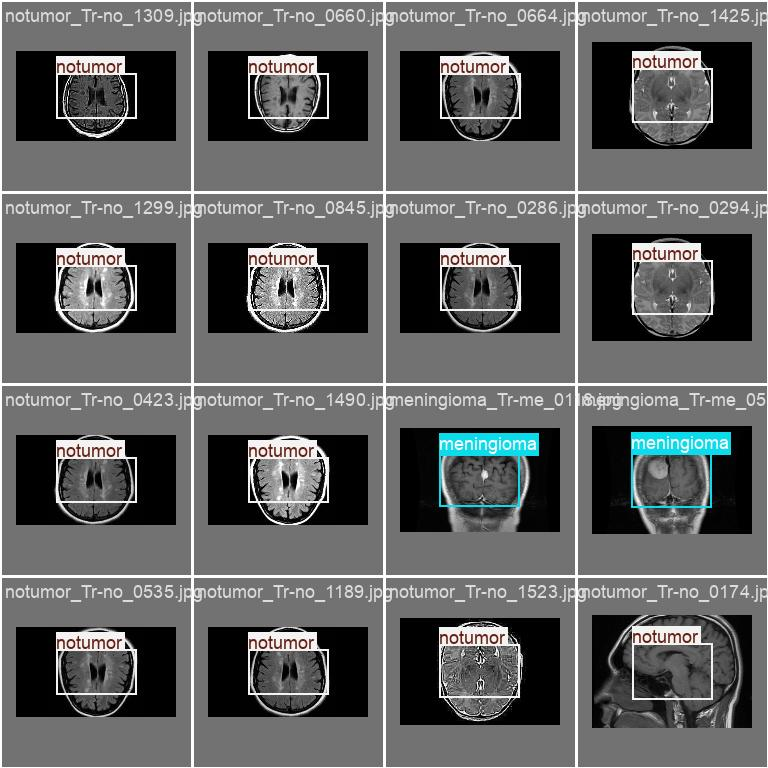

In [ ]:
#Run prediction on one image
import glob
import random

#Automatically pick a real validation image
val_images = glob.glob('/content/dataset/images/val/*.jpg') + glob.glob('/content/dataset/images/val/*.png')
test_image_path = random.choice(val_images)

results = model.predict(source=test_image_path, save=True)

#Display predicted image
from IPython.display import Image as IPyImage, display
import glob

predicted_img = glob.glob('runs/detect/*/*.jpg')[-1]
display(IPyImage(predicted_img))
